# Focus: Spike inference data example

This notebooks shows an example of the constrained model for Focus. This example is inspired from one application of changepoint detection to spike inference in calcium imaging data. For past developments in the offline setting, see [Jewell and al. (2020)](https://academic.oup.com/biostatistics/article/21/4/709/5310127).

In [308]:
#!python -m pip install '../package/'
#!python -m pip install pandas
#!python -m pip install plotnine
#!python -m pip install ipywidgets

In [326]:
import numpy as np
import pandas as pd
from plotnine import ggplot, aes, geom_line, geom_vline, theme_minimal, xlim, geom_segment, geom_point
import plotnine as pl
from changepoint_online import *
import pickle

## An introductory example
To explain how to run the costrained recursion in focus, and see what effects it has on the changepoint detections, we generate an artificial example:

In [310]:
np.random.seed(0)
Y = np.concatenate((np.random.normal(loc=0.0, scale=1.0, size=1000),
                    np.random.normal(loc=-2.0, scale=1.0, size=1000),
                    np.random.normal(loc=1.0, scale=1.0, size=1000)))

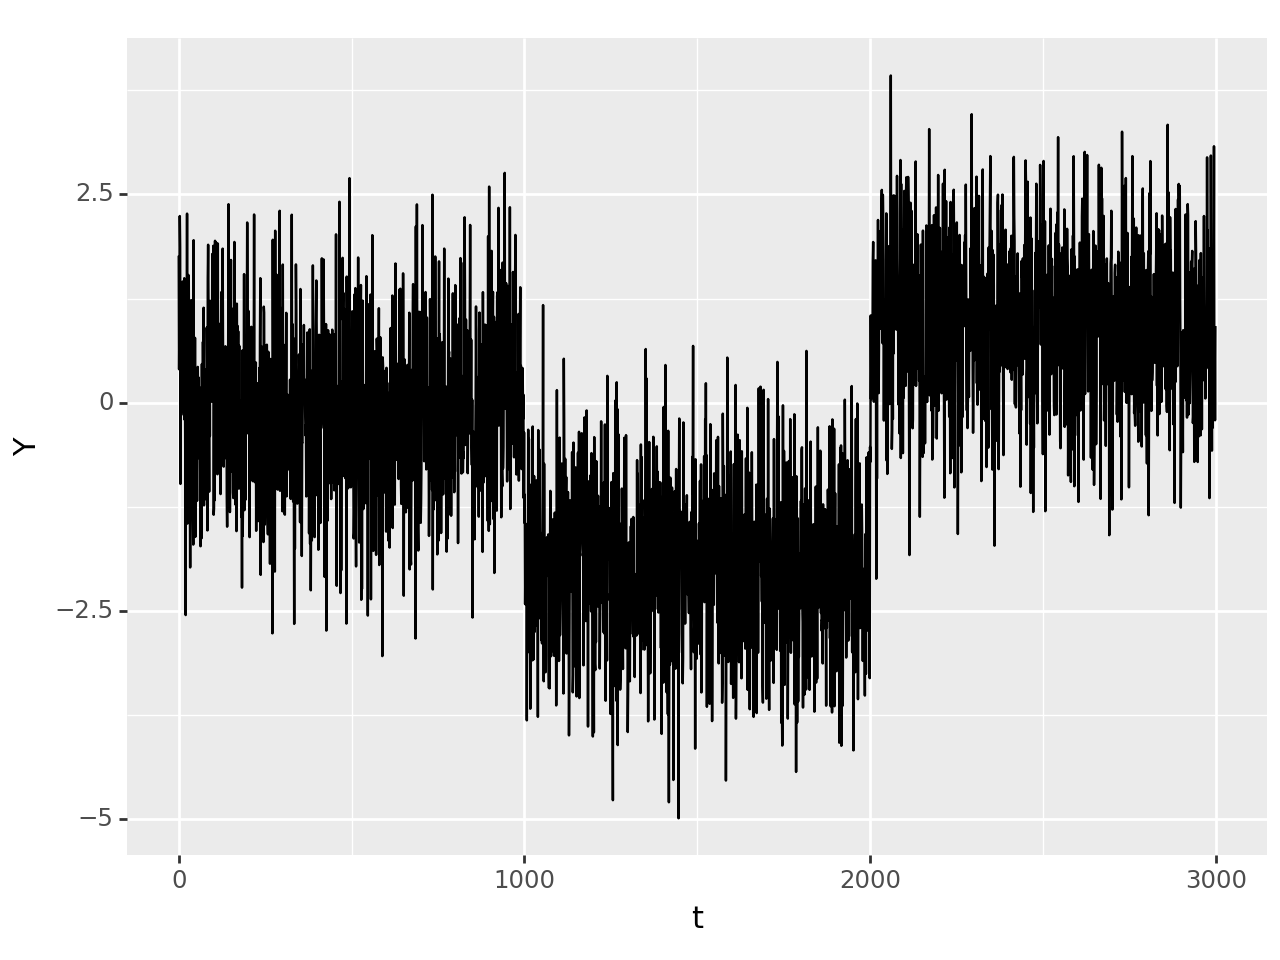

<Figure Size: (640 x 480)>

In [311]:
df = pd.DataFrame({'t' : range(Y.size), 'Y': Y})
(ggplot(df, aes(x='t', y='Y')) +
        geom_line())

For detecting just up changes we can specify:

In [312]:
threshold = 10.0

detector = Focus(Gaussian(), side="right")
for y in Y:
    detector.update(y)
    if detector.statistic() >= threshold:
        break
detector.changepoint()

{'stopping_time': 2009, 'changepoint': 2002}

Similarly, for detecting just down changes we can specify:

In [313]:
threshold = 10.0

detector = Focus(Gaussian(), side="left")
for y in Y:
    detector.update(y)
    if detector.statistic() >= threshold:
        break
detector.changepoint()

{'stopping_time': 1008, 'changepoint': 1000}

## Constrained Up-Down model for spike inference

Now this constrained optimization can be useful for detecting spikes in calcium-imaging data. In this context, a spike is equivalent to a neuron firing. Following a spike we find an exponential decay.

In [314]:
with open("exe_trace.pkl", "rb") as f:
    neur_trace = pickle.load(f)

Plotting the trace (and the real spike times, in orange below the calcium trace):

/home/romano/Documents/changepoint.online/.venv/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:98: PlotnineWarning: geom_path: Removed 37229 rows containing missing values.
/home/romano/Documents/changepoint.online/.venv/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_segment : Removed 739 rows containing missing values.


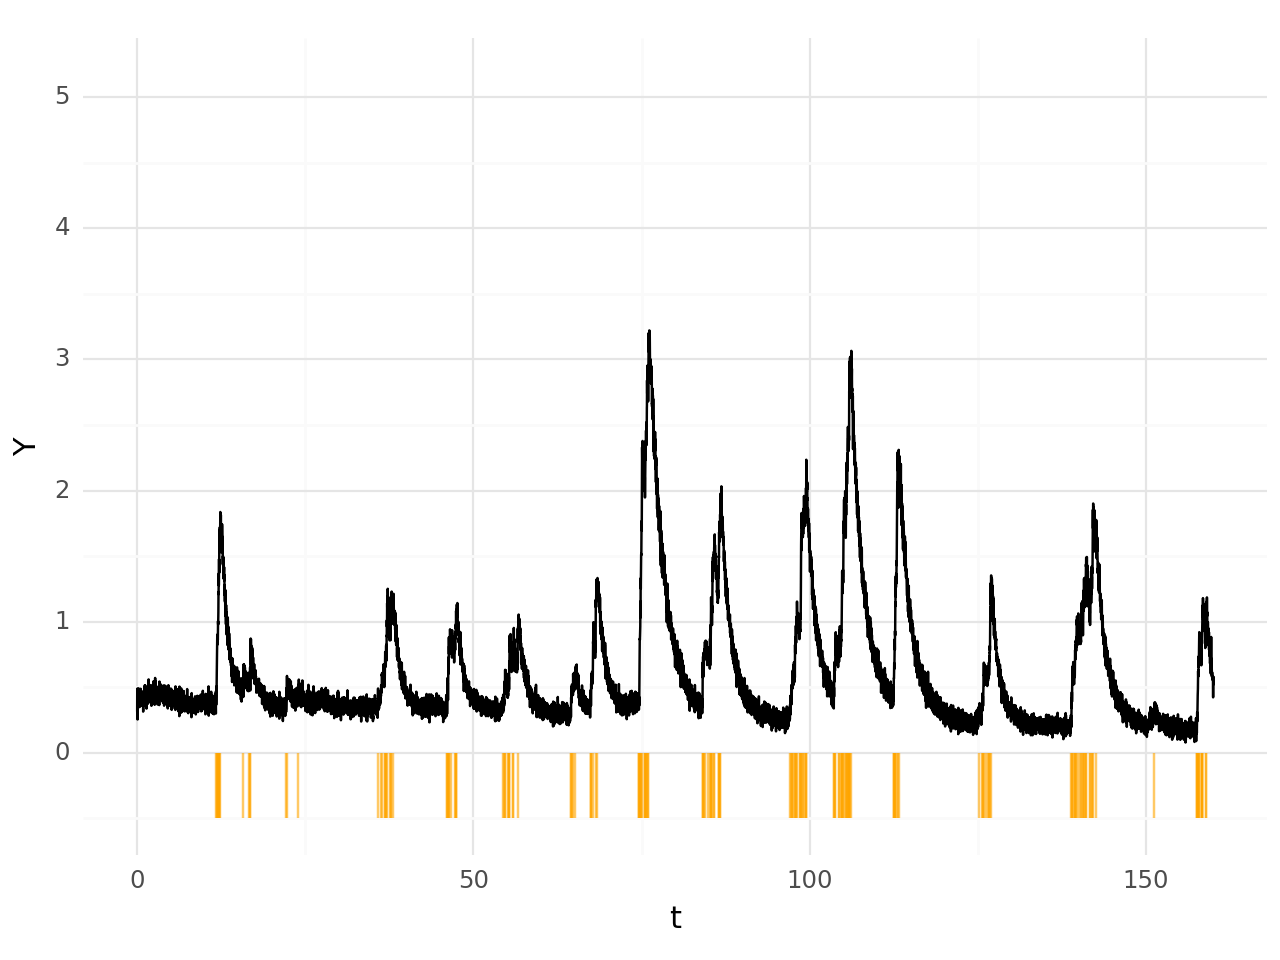

<Figure Size: (640 x 480)>

In [315]:
# Define the y position for the segments
y_position = 0
plt_seg_range = -.5


# Create a new DataFrame for the spikes
df_spikes = pd.DataFrame({
    't': neur_trace["spikes"],
    'y': [y_position] * len(neur_trace["spikes"]),
    'yend': [y_position + plt_seg_range] * len(neur_trace["spikes"])
})

df = pd.DataFrame({'t' : neur_trace["time"], 'Y': neur_trace["trace"]})

(ggplot(df, aes(x='t', y='Y')) + 
    geom_line() + 
    geom_segment(df_spikes, aes(x = 't', xend = 't', y = 'y', yend = 'yend'), alpha = 0.6, colour = "orange") +
    xlim(0, 160)+
    theme_minimal()
)


We can run a two-states constrained model to keep track of the up state and the decay state.  
To do so, at every iteration we run two changepoint detectors, one focusing on the left-changes (decay) and one for the right-changes (increase, equivalent to a neuron firing). Every time one of the two detectors passes the relative threshold, we re-initialize the model. 

In [316]:
# change this to focus on a smaller part of the trace
lower, upper = 0, len(neur_trace["trace"])
Y = neur_trace["trace"][lower:upper]
time = neur_trace["time"][lower:upper]

# thresholds for up and down changes
r_threshold = .2
l_threshold = 1

# init of the two detectors
r_detector = Focus(Gaussian(), side="right")
l_detector = Focus(Gaussian(), side="left")

cpt_found = False
stp_list = []
seg_type = []
r_stat = []
l_stat = []

for t, y in enumerate(Y):

    # updating both the right and left detectors
    r_detector.update(y)
    l_detector.update(y)

    # ... and the statistics
    r_stat.append(r_detector.statistic())
    l_stat.append(l_detector.statistic())

    # if either pass a treshold
    if r_stat[-1] > r_threshold:
        cpt_found = True
        type = "right"
    elif l_stat[-1] > l_threshold:
        cpt_found = True
        type = "left"

    # we record the change and re-initialize the detectors
    if cpt_found:
        stp_list.append(time[t])
        seg_type.append(type)
        
        cpt_found = False
        r_detector = Focus(Gaussian(), side="right")
        l_detector = Focus(Gaussian(), side="left")



We can see that by focusing only on the up states, we are able to reconstruct the neuron firing in real-time with relatively short delay (few milliseconds), few missed detections, and no false positives.

/home/romano/Documents/changepoint.online/.venv/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:98: PlotnineWarning: geom_path: Removed 37229 rows containing missing values.
/home/romano/Documents/changepoint.online/.venv/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_segment : Removed 739 rows containing missing values.
/home/romano/Documents/changepoint.online/.venv/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_segment : Removed 162 rows containing missing values.
/home/romano/Documents/changepoint.online/.venv/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:98: PlotnineWarning: geom_path: Removed 37229 rows containing missing values.


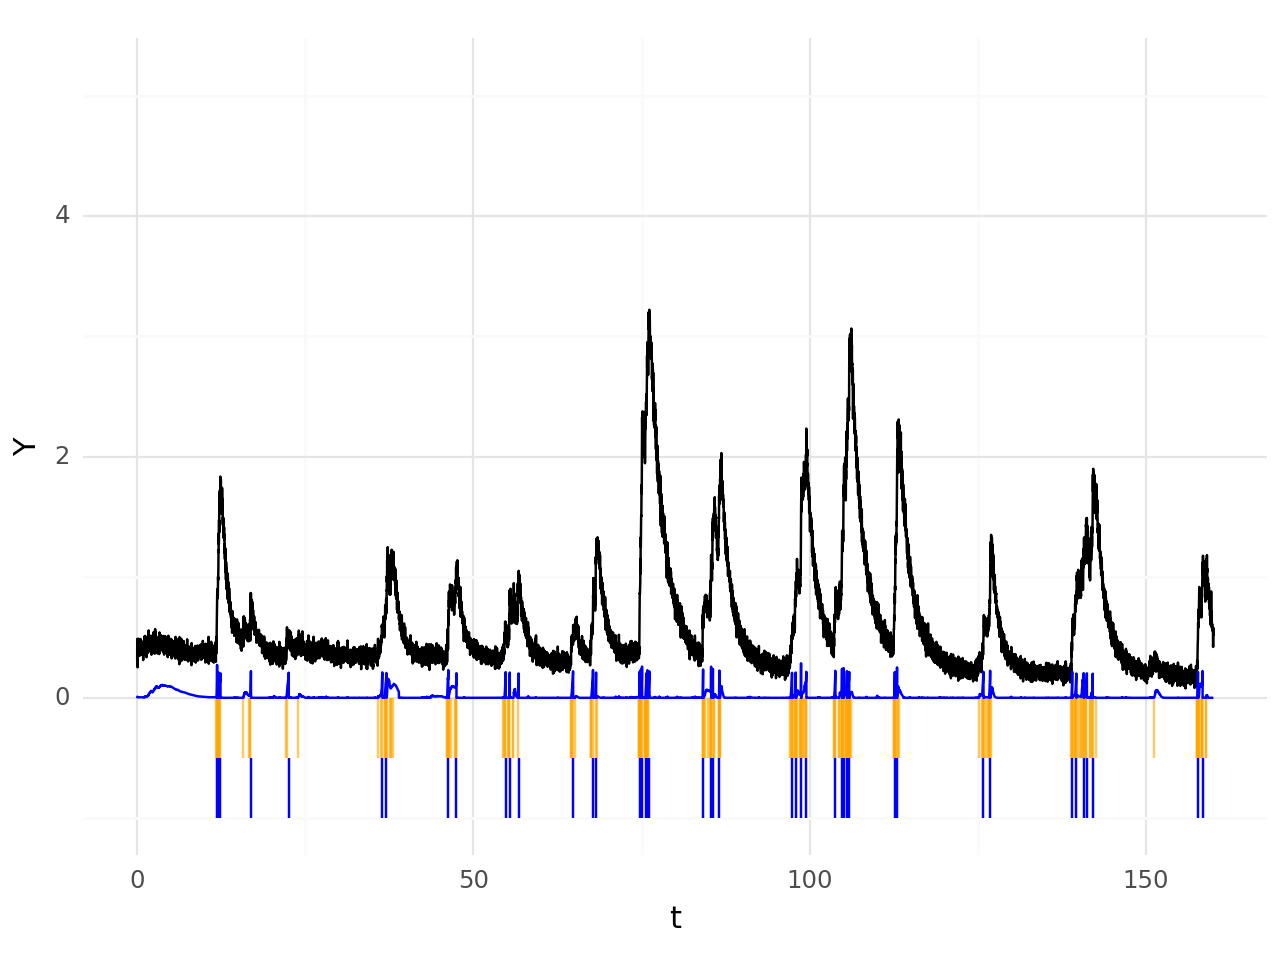

<Figure Size: (640 x 480)>

In [318]:
# Define the y position for the segments
y_position = 0
plt_seg_range = -.5

# Create a new DataFrame for the spikes
df_spikes = pd.DataFrame({
    't': neur_trace["spikes"],
    'y': [y_position] * len(neur_trace["spikes"]),
    'yend': [y_position + plt_seg_range] * len(neur_trace["spikes"])
})

y_position = - 0.5

# Create a new DataFrame for the changes
df_changes = pd.DataFrame({
    't': stp_list,
    'y': [y_position] * len(stp_list),
    'yend': [y_position + plt_seg_range] * len(stp_list),
    'type': seg_type
})

df = pd.DataFrame({'t' : time, 'Y': Y})

# uncomment line to plot traces/segments for either up and down changes. 
(ggplot(df, aes(x='t', y='Y')) + 
    geom_line() + 
    geom_segment(df_spikes, aes(x = 't', xend = 't', y = 'y', yend = 'yend'), alpha = 0.6, colour = "orange") +
    geom_segment(df_changes.query('type == "right"'), aes(x = 't', xend = 't', y = 'y', yend = 'yend'), colour = "blue") +
    #geom_segment(df_changes.query('type == "left"'), aes(x = 't', xend = 't', y = 'y', yend = 'yend'), colour = "red") +
    geom_line(pd.DataFrame({'t' : time, 'Y': r_stat}), aes(x='t', y='Y'), colour = "blue") + 
    #geom_line(pd.DataFrame({'t' : time, 'Y': l_stat}), aes(x='t', y='Y'), colour = "red") + 
    #xlim(time[0], time[-1])+
    xlim(0, 160)+ # change here to see different zooms
    theme_minimal()
)


/home/romano/Documents/changepoint.online/.venv/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:98: PlotnineWarning: geom_path: Removed 53048 rows containing missing values.
/home/romano/Documents/changepoint.online/.venv/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_segment : Removed 926 rows containing missing values.
/home/romano/Documents/changepoint.online/.venv/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_segment : Removed 203 rows containing missing values.
/home/romano/Documents/changepoint.online/.venv/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:98: PlotnineWarning: geom_path: Removed 53048 rows containing missing values.


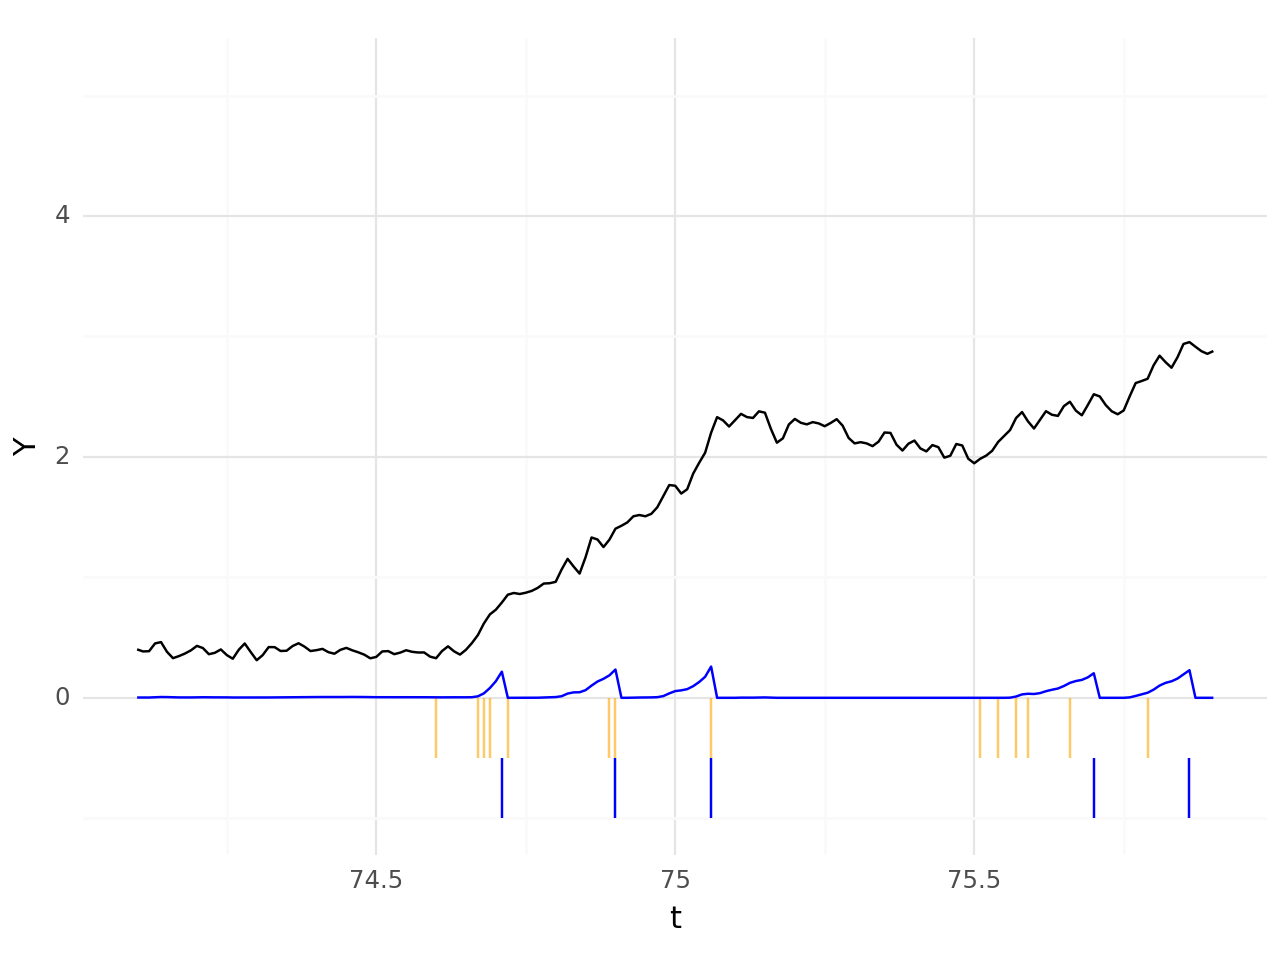

<Figure Size: (640 x 480)>

In [336]:
(ggplot(df, aes(x='t', y='Y')) + 
    geom_line() + 
    geom_segment(df_spikes, aes(x = 't', xend = 't', y = 'y', yend = 'yend'), alpha = 0.6, colour = "orange") +
    geom_segment(df_changes.query('type == "right"'), aes(x = 't', xend = 't', y = 'y', yend = 'yend'), colour = "blue") +
    #geom_segment(df_changes.query('type == "left"'), aes(x = 't', xend = 't', y = 'y', yend = 'yend'), colour = "red") +
    geom_line(pd.DataFrame({'t' : time, 'Y': r_stat}), aes(x='t', y='Y'), colour = "blue") + 
    #geom_line(pd.DataFrame({'t' : time, 'Y': l_stat}), aes(x='t', y='Y'), colour = "red") + 
    #xlim(time[0], time[-1])+
    xlim(74.1, 75.9)+ # change here to see different zooms
    theme_minimal()
)